In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cvx.retirement.utils import transform_data, inverse_transform_data, solve_ar, get_stationary_cov
from cvx.retirement.data_loader import load_data


sns.set_theme(font_scale=1.5, style='whitegrid')

%load_ext autoreload
%autoreload 2

In [2]:
def ecdf(x):
    return np.arange(1, len(x)+1) / len(x)

def plot_ecdf(data, label):
    plt.plot(np.sort(data), ecdf(data), label=label)

# Data

In [3]:
data = load_data()

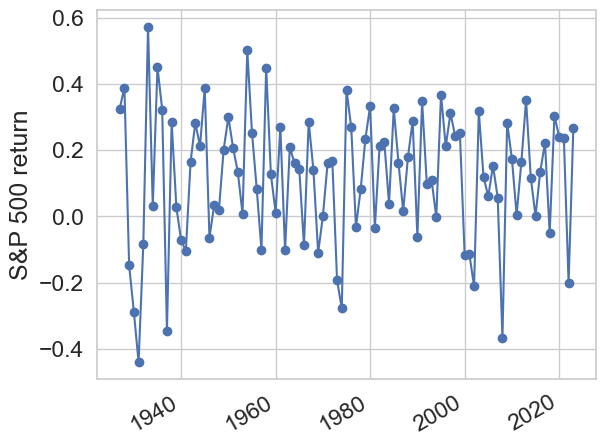

In [4]:
data.sp500.plot(marker='o')
plt.ylabel('S&P 500 return')
plt.gcf().autofmt_xdate()
plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/retirement/retirement-paper/figures/sp500_historical.png', dpi=300, bbox_inches='tight')

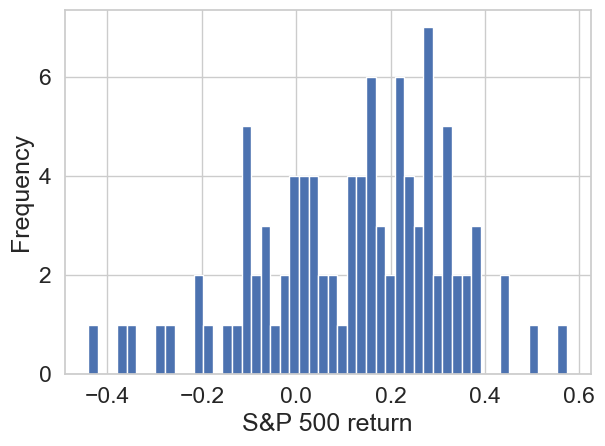

In [5]:
data.sp500.hist(bins=50)
plt.xlabel('S&P 500 return')
plt.ylabel('Frequency')
plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/retirement/retirement-paper/figures/sp500_historical_hist.png', dpi=300, bbox_inches='tight')

In [6]:
quantiles = data.sp500.quantile([0.1, 0.3, 0.5, 0.7, 0.9])
mean = data.sp500.mean()
std = data.sp500.std()

print(f'10th percentile: {quantiles[0.1]:.1%}')
print(f'30th percentile: {quantiles[0.3]:.1%}')
print(f'50th percentile: {quantiles[0.5]:.1%}')
print(f'70th percentile: {quantiles[0.7]:.1%}')
print(f'90th percentile: {quantiles[0.9]:.1%}')
print(f'Mean: {mean:.1%}')
print(f'Standard deviation: {std:.1%}')

10th percentile: -11.5%
30th percentile: 1.5%
50th percentile: 15.4%
70th percentile: 24.2%
90th percentile: 33.9%
Mean: 12.0%
Standard deviation: 20.0%


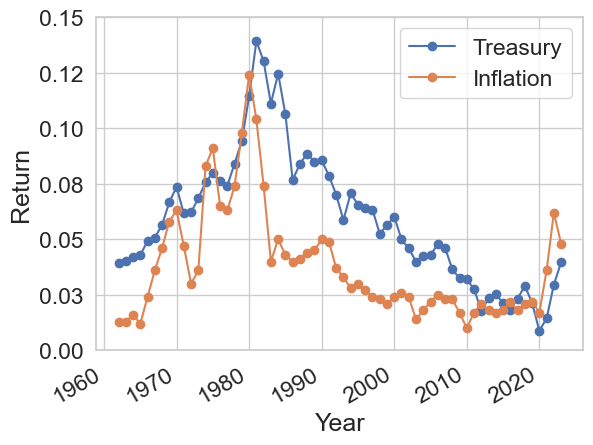

In [7]:
plt.figure()
data.treasury.loc[1962:].plot(marker='o', label='Treasury')
data.inflation.loc[1962:].plot(marker='o', label='Inflation')
plt.ylabel('Return')
plt.legend()
plt.gcf().autofmt_xdate()
plt.ylim(0, 0.15)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/retirement/retirement-paper/figures/treasury_inflation.png', dpi=300, bbox_inches='tight')


# GMM

In [8]:
# Fit sp500 GMM
from sklearn.mixture import GaussianMixture
gmm_ret = GaussianMixture(n_components=3, random_state=9)
gmm_ret.fit(data.sp500.values.reshape(-1, 1));
samples = gmm_ret.sample(1000)

In [9]:
print(f'Mean: {gmm_ret.means_.flatten()}')
print(f'Weights: {gmm_ret.weights_.flatten()}')
print(f'Stdevs: {gmm_ret.covariances_.flatten() ** 0.5}')

Mean: [ 0.28476902 -0.10998001  0.1052612 ]
Weights: [0.37764191 0.24699381 0.37536428]
Stdevs: [0.10744    0.15709504 0.12416913]


In [10]:
# sample 1000 points from the GMM
samples = gmm_ret.sample(1000)

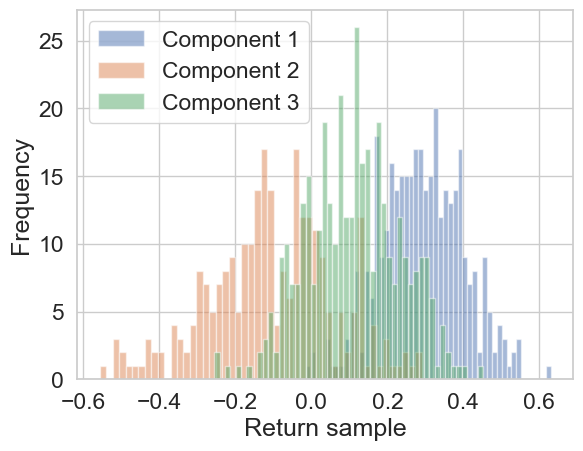

In [11]:
#  pd.Series(samples[0].flatten()).hist(bins=50) but color by the component
plt.figure()
zero_inds = np.where(samples[1] == 0)
one_inds = np.where(samples[1] == 1)
two_inds = np.where(samples[1] == 2)
plt.hist(samples[0][zero_inds].flatten(), bins=50, alpha=0.5, label='Component 1')
plt.hist(samples[0][one_inds].flatten(), bins=50, alpha=0.5, label='Component 2');
plt.hist(samples[0][two_inds].flatten(), bins=50, alpha=0.5, label='Component 3');
plt.xlabel('Return sample')
plt.ylabel('Frequency')
plt.legend();
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/retirement/retirement-paper/figures/sp500_gmm.png', dpi=300, bbox_inches='tight')

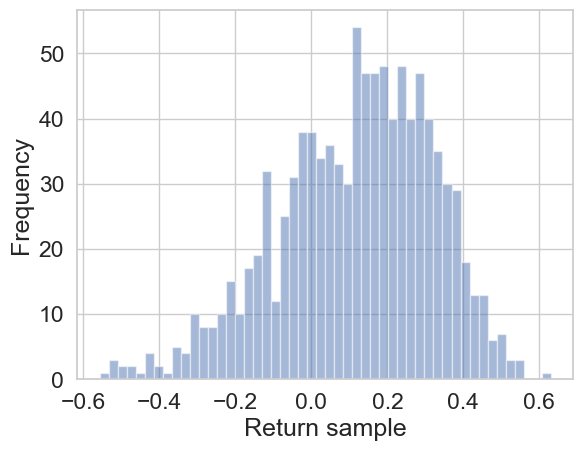

In [12]:
plt.hist(samples[0].flatten(), bins=50, alpha=0.5)
plt.xlabel('Return sample')
plt.ylabel('Frequency');
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/retirement/retirement-paper/figures/sp500_gmm_all.png', dpi=300, bbox_inches='tight')

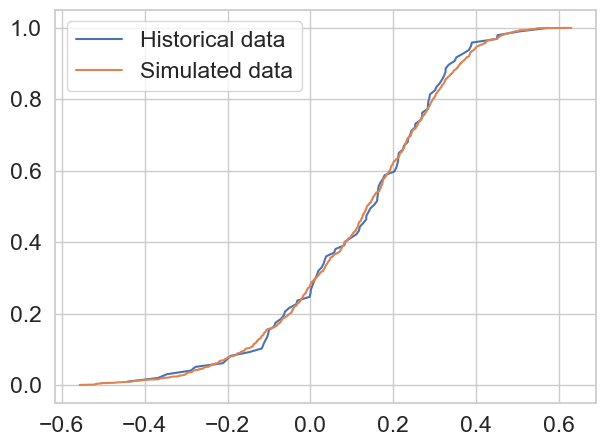

In [ ]:
plt.plot(data.sp500.iloc[np.argsort(ecdf_sp500(data.sp500))], np.sort(ecdf_sp500(data.sp500)), label='Historical data');
plt.plot(samples[0][np.argsort(ecdf_samples(samples[0].flatten()))], np.sort(ecdf_samples(samples[0].flatten())), label='Simulated data');
plt.legend()
plt.tight_layout();
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/retirement/retirement-paper/figures/cdf.png', bbox_inches='tight')

In [ ]:
quantiles = data.sp500.quantile([0.1, 0.3, 0.5, 0.7, 0.9])
mean = data.sp500.mean()
std = data.sp500.std()

print(f'10th percentile: {quantiles[0.1]:.1%}')
print(f'30th percentile: {quantiles[0.3]:.1%}')
print(f'50th percentile: {quantiles[0.5]:.1%}')
print(f'70th percentile: {quantiles[0.7]:.1%}')
print(f'90th percentile: {quantiles[0.9]:.1%}')
print(f'Mean: {mean:.1%}')
print(f'Volatility: {std:.1%}')

10th percentile: -11.5%
30th percentile: 1.5%
50th percentile: 15.4%
70th percentile: 24.2%
90th percentile: 33.9%
Mean: 12.0%
Volatility: 20.0%


In [ ]:
samples_series = pd.Series(samples[0].flatten())

quantiles = samples_series.quantile([0.1, 0.3, 0.5, 0.7, 0.9])
mean = samples_series.mean()
std = samples_series.std()

print(f'10th percentile: {quantiles[0.1]:.1%}')
print(f'30th percentile: {quantiles[0.3]:.1%}')
print(f'50th percentile: {quantiles[0.5]:.1%}')
print(f'70th percentile: {quantiles[0.7]:.1%}')
print(f'90th percentile: {quantiles[0.9]:.1%}')
print(f'Mean: {mean:.1%}')
print(f'Volatility: {std:.1%}')

10th percentile: -15.7%
30th percentile: 1.4%
50th percentile: 13.6%
70th percentile: 24.2%
90th percentile: 36.3%
Mean: 11.7%
Volatility: 20.4%


# Treasury and inflation

In [ ]:
from cvx.retirement.utils import gmm_sample
from collections import namedtuple
InfTreasAR = namedtuple('InfTreasAR', ['a0', 'A', 'mu_eps', 'Sigma_eps', 'Sigma'])
k, s1, s2 = data.inflation.median(), 2.5, 0.75

inflation_transformed = transform_data(data.inflation, k, s1, s2)

In [ ]:
X = pd.concat([inflation_transformed, data.treasury], axis=1).dropna()

a0, A = solve_ar(X.values)
eps = (X.shift(-1).values - a0 - (X.values-a0) @ A.T)[:-1]
mu_eps = np.mean(eps, axis=0)
Sigma_eps = np.cov(eps.T)
inf_treas_ar = InfTreasAR(a0, A, mu_eps, Sigma_eps, get_stationary_cov(A, np.cov(eps.T)))

In [ ]:
### The order in the paper; treasury, inflation instead of inflation, treasury

# X = pd.concat([data.treasury, inflation_transformed], axis=1).dropna()

# a0, A = solve_ar(X.values)
# eps = (X.shift(-1).values - a0 - (X.values-a0) @ A.T)[:-1]
# mu_eps = np.mean(eps, axis=0)
# Sigma_eps = np.cov(eps.T)
# inf_treas_ar = InfTreasAR(a0, A, mu_eps, Sigma_eps, get_stationary_cov(A, np.cov(eps.T)))

# inf_treas_ar.a0
# inf_treas_ar.A
# inf_treas_ar.Sigma_eps
# inf_treas_ar.Sigma

In [ ]:
def simulate_inf_treas(seed):
    np.random.seed(seed)
    _eps = pd.DataFrame([np.random.multivariate_normal(np.zeros(2), inf_treas_ar.Sigma_eps) for _ in range(data.sp500.shape[0])], index=data.sp500.index, columns=['Inflation', 'Treasury'])

    df = pd.DataFrame(columns=['Inflation', 'Treasury'], index=range(1962, 2024), dtype=float)
    df.loc[1962] =  np.array([transform_data(data.inflation.loc[1962], k, s1, s2), data.treasury.loc[1962].item()])

    for time_prev, time in zip(range(1962, 2023), range(1963, 2024)):
        inf_treas_prev = df.loc[time_prev].values
        df.loc[time] = inf_treas_ar.a0 + inf_treas_ar.A @ (inf_treas_prev - inf_treas_ar.a0) + _eps.loc[time].values

    df['Inflation'] = inverse_transform_data(df['Inflation'], k, s1, s2)
    return df[['Treasury', 'Inflation']]

<Figure size 640x480 with 0 Axes>

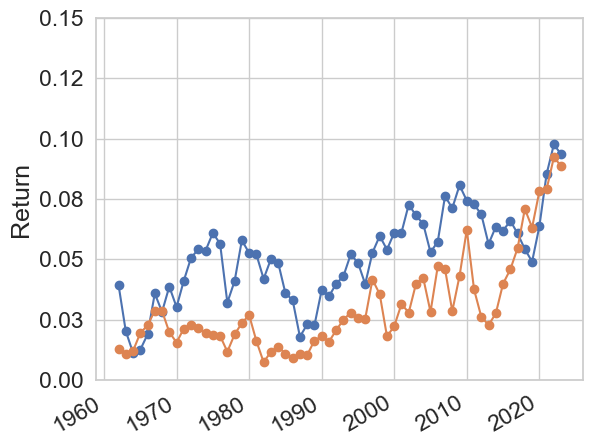

<Figure size 640x480 with 0 Axes>

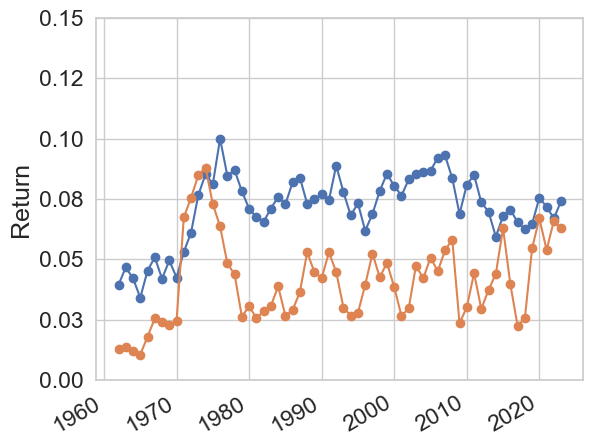

In [ ]:
plt.figure()
df = simulate_inf_treas(0)
df.plot(marker='o')
plt.ylabel('Return')
plt.tight_layout()
plt.ylim(0.0, 0.15)
plt.gcf().autofmt_xdate()
plt.legend().remove()
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/retirement/retirement-paper/figures/inflation_treasury_sim1.png', dpi=300, bbox_inches='tight')

plt.figure()
df = simulate_inf_treas(3)
df.plot(marker='o')
plt.ylabel('Return')
plt.tight_layout()
plt.legend().remove()
plt.ylim(0.0, 0.15)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/retirement/retirement-paper/figures/inflation_treasury_sim2.png', dpi=300, bbox_inches='tight');

### Predict

In [ ]:
def predict_inf_treas(x0, mu, A, n_steps, year_start=1962):

    predictions = pd.DataFrame(columns=['Inflation', 'Treasury'], index=range(year_start, year_start+n_steps), dtype=float)
    predictions.loc[year_start] = x0
    predictions.loc[year_start, 'Inflation'] = transform_data(predictions.loc[year_start, 'Inflation'], k, s1, s2)

    for time in range(year_start+1, year_start+n_steps+1):
        predictions.loc[time] = mu + A @ (predictions.loc[time-1] - mu)
    
    predictions['Inflation'] = inverse_transform_data(predictions['Inflation'], k, s1, s2)
    
    return predictions

In [ ]:
data.treasury

Date
1962    0.039461
1963    0.040016
1964    0.041874
1965    0.042837
1966    0.049250
          ...   
2019    0.021363
2020    0.008835
2021    0.014405
2022    0.029568
2023    0.039650
Name: Close, Length: 62, dtype: float64

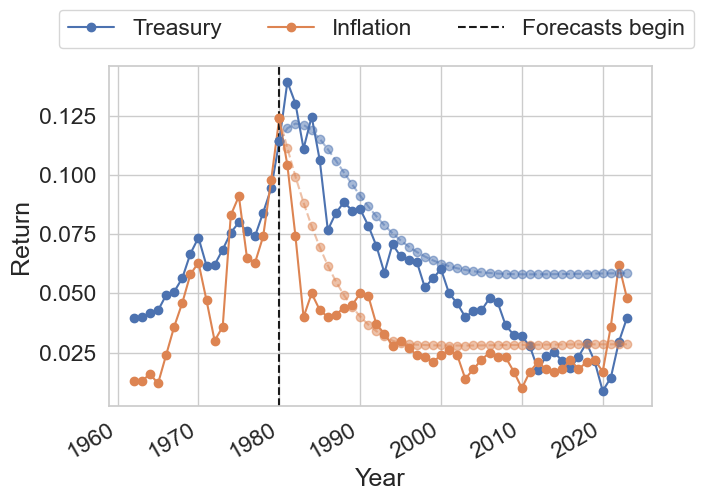

In [ ]:
x0 = np.array([data.inflation[1980], data.treasury.loc[1980]])
predictions = predict_inf_treas(x0, inf_treas_ar.a0, inf_treas_ar.A, 43, year_start=1980)

plt.figure(figsize=(7, 5))
data.treasury.loc[1962:1980].plot(marker='o', label='Treasury', c='C0')
data.inflation.loc[1962:1980].plot(marker='o', label='Inflation', c='C1')
plt.axvline(1980, linestyle='--', c='k', label='Predictions begin')
data.treasury.loc[1980:].plot(marker='o', label='Treasury', c='C0')
data.inflation.loc[1980:].plot(marker='o', label='Inflation', c='C1')
predictions.Treasury.loc[:].plot(marker='o', label='Treasury', c='C0', linestyle='--', alpha=0.5)
predictions.Inflation.loc[:].plot(marker='o', label='Inflation', c='C1', linestyle='--', alpha=0.5)
plt.ylabel('Return')
plt.legend(['Treasury', 'Inflation', 'Forecasts begin'], ncol=3, bbox_to_anchor=(1.1, 1.2))
plt.gcf().autofmt_xdate()
# plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/retirement/retirement-paper/figures/inflation_treasury_forecast_1980.png', dpi=300, bbox_inches='tight')


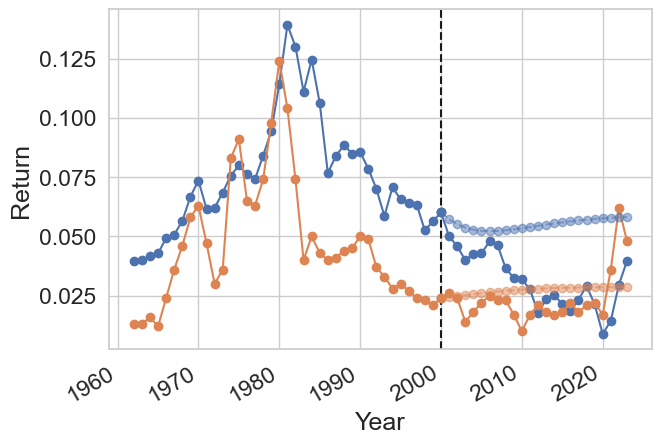

In [ ]:
pred_date = 2000

x0 = np.array([data.inflation[pred_date], data.treasury[pred_date]])
predictions = predict_inf_treas(x0, inf_treas_ar.a0, inf_treas_ar.A, 23, year_start=pred_date)

plt.figure(figsize=(7, 5))
data.treasury.loc[1962:pred_date].plot(marker='o', label='Treasury', c='C0')
data.inflation.loc[1962:pred_date].plot(marker='o', label='Inflation', c='C1')
plt.axvline(pred_date, linestyle='--', c='k', label='Predictions begin')
data.treasury.loc[pred_date:].plot(marker='o', label='Treasury', c='C0')
data.inflation.loc[pred_date:].plot(marker='o', label='Inflation', c='C1')
predictions.Treasury.loc[:].plot(marker='o', label='Treasury', c='C0', linestyle='--', alpha=0.5)
predictions.Inflation.loc[:].plot(marker='o', label='Inflation', c='C1', linestyle='--', alpha=0.5)
plt.ylabel('Return')
# plt.legend(['Treasury', 'Inflation', 'Predictions begin'], ncol=3, bbox_to_anchor=(1.1, 1.2))
plt.gcf().autofmt_xdate()
# plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/retirement/retirement-paper/figures/inflation_treasury_forecast_2000.png', dpi=300, bbox_inches='tight')


# Metrics

In [ ]:
def get_metrics(treas_inf):
    mean = treas_inf.mean().values
    std = treas_inf.std().values
    quantiles = treas_inf.quantile([0.25, 0.5, 0.75]).values
    corr = treas_inf.corr().iloc[0, 1]

    return mean, std, quantiles, corr

In [ ]:
treas_inf = pd.concat([data.treasury, data.inflation], axis=1).dropna()
mean, std, quantiles, corr = get_metrics(treas_inf)
print('Historical data')
print(f'\nMean: {mean}')
print(f'Standard deviation: {std}')
print(f'Quantiles:\n {quantiles}')
print(f'Correlation: {corr}')

Historical data

Mean: [0.05869372 0.03803226]
Standard deviation: [0.02963251 0.02477503]
Quantiles:
 [[0.03950807 0.021     ]
 [0.05639606 0.029     ]
 [0.07600142 0.04775   ]]
Correlation: 0.7202600828222097


In [ ]:
np.random.seed(0)
rates = [simulate_inf_treas(s) for s in np.random.randint(0, 100000, 1000)]

In [ ]:
treas_sim = pd.concat([r.Treasury for r in rates], axis=0)
inf_sim = pd.concat([r.Inflation for r in rates], axis=0)

treas_inf_sim = pd.concat([treas_sim, inf_sim], axis=1)

mean, std, quantiles, corr = get_metrics(treas_inf_sim)
print('Simulated data')
print(f'\nMean: {mean}')
print(f'Standard deviation: {std}')
print(f'Quantiles:\n {quantiles}')
print(f'Correlation: {corr}')

Simulated data

Mean: [0.05326556 0.03487732]
Standard deviation: [0.0281286  0.02202506]
Quantiles:
 [[0.03407125 0.0200132 ]
 [0.05208035 0.02714676]
 [0.07200519 0.04629841]]
Correlation: 0.6984746750204441


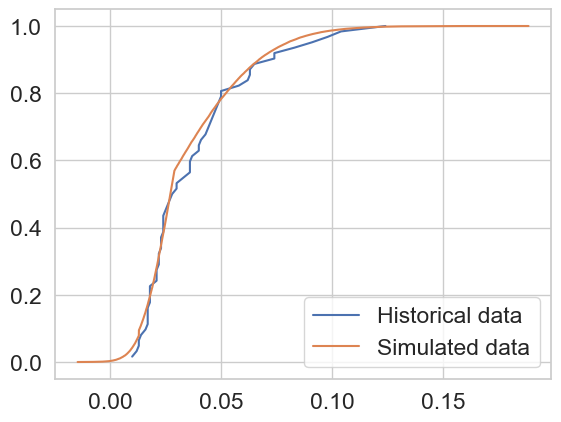

In [ ]:
plot_ecdf(treas_inf.iloc[:, 1], 'Historical data')
plot_ecdf(treas_inf_sim.iloc[:, 1], 'Simulated data')
plt.legend();

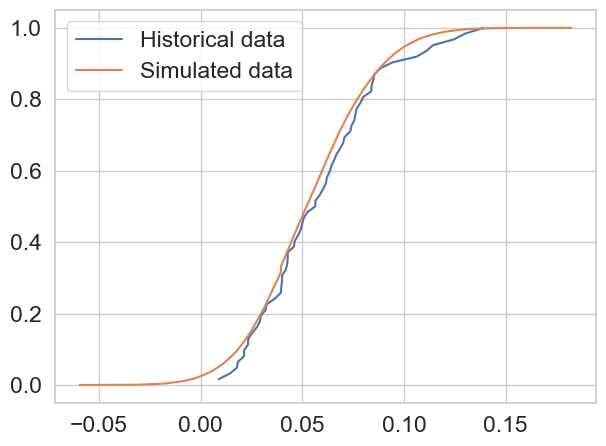

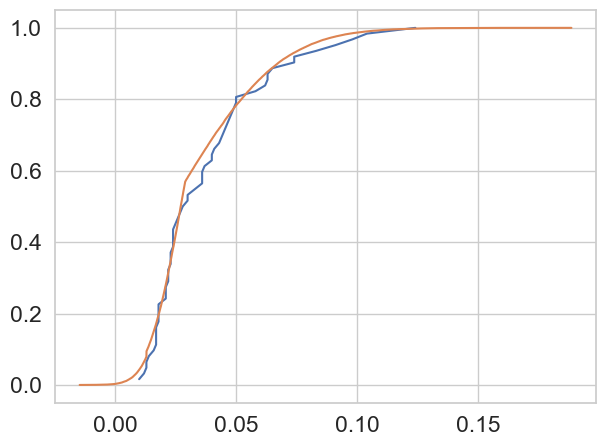

In [ ]:
plt.figure()
plot_ecdf(treas_inf.iloc[:, 0], 'Historical data')
plot_ecdf(treas_inf_sim.iloc[:, 0], 'Simulated data')
plt.legend()
plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/retirement/retirement-paper/figures/treasury_cdf.png', bbox_inches='tight')

plt.figure()
plot_ecdf(treas_inf.iloc[:, 1], 'Historical data')
plot_ecdf(treas_inf_sim.iloc[:, 1], 'Simulated data')
plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/retirement/retirement-paper/figures/inflation_cdf.png', bbox_inches='tight')

# Portfolios

In [ ]:
def get_portfolio_metrics(returns):
    mean = returns.mean()
    std = returns.std()
    quantiles = returns.quantile([0.25, 0.5, 0.75])

    return mean, std, quantiles

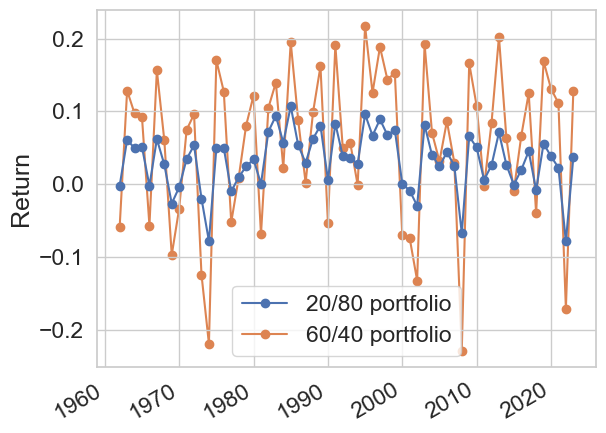

In [ ]:
port_20_80 = (0.2 * data.sp500 + 0.8 * data.treasury - data.inflation).dropna()
port_60_40 = (0.6 * data.sp500 + 0.4 * data.treasury - data.inflation).dropna()

plt.figure()
port_20_80.plot(marker='o', label='20/80 portfolio', zorder=2)
port_60_40.plot(marker='o', label='60/40 portfolio', zorder=0)

# bonds.plot(marker='o', label='Bond portfolio')
# bonds_stocks.plot(marker='o', label='40/60 portfolio')
plt.ylabel('Return')
plt.xlabel('')
plt.legend()
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/retirement/retirement-paper/figures/portfolio_returns.png', dpi=300, bbox_inches='tight')

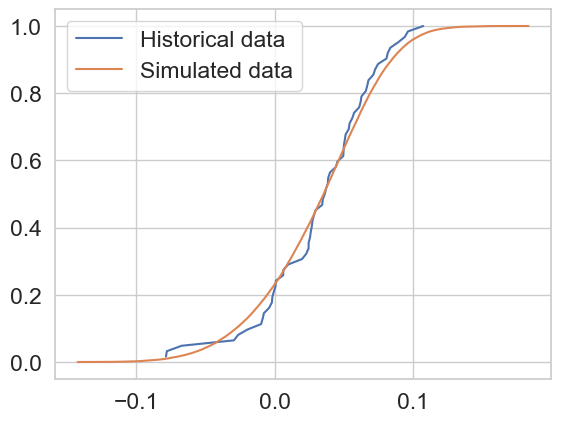

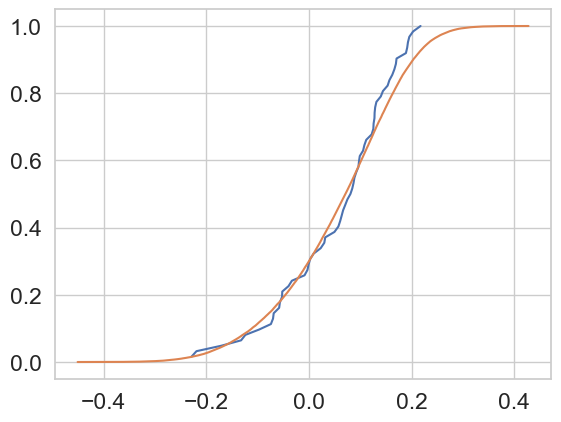

In [ ]:
# simulate
np.random.seed(0)

port_20_80_sim = (0.2 * gmm_ret.sample(treas_inf_sim.shape[0])[0] + 0.8 * treas_inf_sim.iloc[:, 0].values.reshape(-1, 1) - treas_inf_sim.iloc[:, 1].values.reshape(-1, 1)).flatten()
port_60_40_sim = (0.6 * gmm_ret.sample(treas_inf_sim.shape[0])[0] + 0.4 * treas_inf_sim.iloc[:, 0].values.reshape(-1, 1) - treas_inf_sim.iloc[:, 1].values.reshape(-1, 1)).flatten()


plt.figure()
plot_ecdf(port_20_80, 'Historical data')
plot_ecdf(port_20_80_sim, 'Simulated data')
plt.legend()
plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/retirement/retirement-paper/figures/2080_portfolio_cdf.png', dpi=300, bbox_inches='tight')

plt.figure()
plot_ecdf(port_60_40, None)
plot_ecdf(port_60_40_sim, None)
plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/retirement/retirement-paper/figures/6040_portfolio_cdf.png', dpi=300, bbox_inches='tight')

In [ ]:
print('### 20/80 portfolio ###')
mean, std, quantiles = get_portfolio_metrics(pd.Series(port_20_80))
print('\nHistorical data')
print(f'Mean: {mean:.1%}')
print(f'Standard deviation: {std:.1%}')
print(f'Quantiles:\n {quantiles}')
mean, std, quantiles = get_portfolio_metrics(pd.Series(port_20_80_sim))
print('\nSimulated data')
print(f'Mean: {mean:.1%}')
print(f'Standard deviation: {std:.1%}')
print(f'Quantiles:\n {quantiles}')
print('\n######################')

print('\n### 60/40 portfolio ###')
mean, std, quantiles = get_portfolio_metrics(pd.Series(port_60_40))
print('\nHistorical data')
print(f'Mean: {mean:.1%}')
print(f'Standard deviation: {std:.1%}')
print(f'Quantiles:\n {quantiles}')
mean, std, quantiles = get_portfolio_metrics(pd.Series(port_60_40_sim))
print('\nSimulated data')
print(f'Mean: {mean:.1%}')
print(f'Standard deviation: {std:.1%}')
print(f'Quantiles:\n {quantiles}')
print('\n######################')




### 20/80 portfolio ###

Historical data
Mean: 3.2%
Standard deviation: 4.0%
Quantiles:
 0.25    0.006071
0.50    0.036554
0.75    0.060016
dtype: float64

Simulated data
Mean: 3.1%
Standard deviation: 4.4%
Quantiles:
 0.25    0.003048
0.50    0.035294
0.75    0.062751
dtype: float64

######################

### 60/40 portfolio ###

Historical data
Mean: 5.5%
Standard deviation: 10.7%
Quantiles:
 0.25   -0.007373
0.50    0.082338
0.75    0.128500
dtype: float64

Simulated data
Mean: 5.7%
Standard deviation: 12.1%
Quantiles:
 0.25   -0.021399
0.50    0.070909
0.75    0.147072
dtype: float64

######################
